In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

In [3]:
from google.colab import files
uploads = files.upload()

Saving train_data.csv to train_data.csv


In [0]:
data = pd.read_csv('train_data.csv')
data.info

In [0]:
target = ["SalePrice"]
numerical = data.select_dtypes(include = ["int64",'float64']).drop(target,axis=1)
numerical_with_null = ['LotFrontage','MasVarArea','GarageYrBit']
ordinal = ['LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
          'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual',
          'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'SaleCondition']
nominal = data.select_dtypes(include = ["object",]).drop(ordinal, axis=1)
#nominal

In [0]:

remove_nulls = data.copy()
for feature in numerical:
  mean = np.mean(remove_nulls[feature])
  remove_nulls[feature] = remove_nulls[feature].fillna(mean)

for feature in ordinal:
  remove_nulls[feature] = remove_nulls[feature].fillna('NULL')

for feature in nominal:
  remove_nulls[feature] = remove_nulls[feature].fillna('NULL')



- In numerical we removed null by use of measure of central tendency (mean)
- In ordinal or nominal we remove the null by replacing with any strings of our choice


In [21]:
# ordinal & nominal
preprocessing = remove_nulls.select_dtypes(include = ['object']).copy()
preprocessing.columns
for feature in ordinal:
  preprocessing[feature] = preprocessing[feature].astype('category')
  if feature in ordinal:
    preprocessing[feature] = preprocessing[feature].cat.codes
dummies = pd.get_dummies(preprocessing[list(nominal)])
preprocessing = pd.concat([dummies, preprocessing], axis=1)
preprocessing = preprocessing.drop(nominal, axis=1)
# preprocessing.head()
# numeric + target
preprocessed_data = pd.concat([preprocessing, remove_nulls[list(numerical)],remove_nulls[target]],axis=1)
# matrix
preprocessed_data.head()


,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,Alley_Grvl,Alley_NULL,Alley_Pave,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,...,Fence,SaleCondition,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,1,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,4,4,2,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,181500
2,0,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,3,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,223500
3,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,4,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,140000
4,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,4,4,5,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,250000


In [0]:
# get the preprocessed feature (X) and the targets(y). Standardize the X values to reduce multicollinearity
# gaussian distribution model has least multicollinearity

all_features = list(preprocessing.columns)
features = preprocessed_data.drop(target, axis=1).copy()
#print(features.values)
X = StandardScaler().fit_transform(features)
Y = preprocessed_data[target]
#X


In [28]:
# Feature selection with PCA
pca = PCA(n_components=2)
latent_features = pca.fit_transform(X)
pca_data = pd.concat([pd.DataFrame(latent_features, columns = ['PC1','PC2']),Y],axis=1)
pca_data.head()

,PC1,PC2,SalePrice
0,3.450005,-1.418014,208500
1,-0.315185,2.914684,181500
2,3.803954,-0.997492,223500
3,-2.157243,-1.105015,140000
4,5.697111,-0.809153,250000


In [33]:
# Regression
x = pca_data.drop(target, axis=1)
y = np.ravel(pca_data[target])
regressor = LassoCV()
regressor.fit(x,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [35]:
coef = regressor.coef_
intercept =  regressor.intercept_
print('The regression function: Z = ',coef[0],'X +',coef[1],'Y + ', intercept)

The regression function: Z =  16636.632453648646 X + -1092.1913516255113 Y +  180921.19589041095


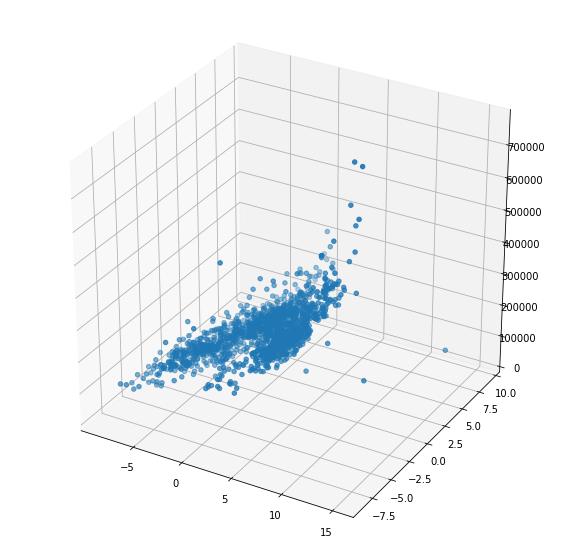

In [36]:
# Plotting the regression function
plt.figure(figsize = (10,10))
axis = plt.axes(projection = '3d')
axis.scatter(x['PC1'],x['PC2'],y)